### CGAN

In [35]:
import tensorflow as tf
print (tf.__version__)
print (tf.keras.__version__)
print (tf.test.is_gpu_available())
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os
import time
import glob


2.2.0
2.3.0-tf
True


In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28,28,1).astype('float32')
train_images = (train_images - 127.5) / 127.5

#####
train_labels = tf.one_hot(train_labels, depth=10)
train_labels = tf.cast(train_labels, tf.float32)
#####
buffer_size = 60000
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(buffer_size).batch(batch_size)

定义生成器

In [37]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(110,)))    ###因为加入了标签信息,发生改变
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape== (None, 7,7,256)

  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
  assert model.output_shape==(None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  assert model.output_shape==(None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation="tanh"))
  assert model.output_shape==(None, 28, 28, 1)

  return model

generator = make_generator_model()
generator.summary()
#noise = tf.random.normal([1, 100])
#generated_image = generator(noise, training=False)
#plt.imshow(generated_image[0, : ,: ,0], cmap='gray')



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 12544)             1379840   
_________________________________________________________________
batch_normalization_9 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 12544)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 7, 7, 128)        

定义判别器

In [38]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,11]))  #加入标签信息
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  return model

discriminator = make_discriminator_model()
discriminator.summary()
#decision = discriminator(generated_image)
#print(decision)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        17664     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

定义损失函数和优化器

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                  discriminator_optimizer=discriminator_optimizer,
                  generator=generator,
                  discriminator=discriminator)

训练模型

In [42]:
 epochs = 100
 noise_dim = 100
 num_examples_to_generator = 100  ####

 seed = tf.random.normal([num_examples_to_generator, noise_dim])


 #####
 labels = [i%10 for i in range(num_examples_to_generator)]
 labels = tf.one_hot(labels, depth=10)
 labels = tf.cast(labels, tf.float32)
 print(seed.shape, labels.shape)
 seed = tf.concat([seed, labels],1)
 print(seed.shape)
 #####

 @tf.function
 def train_step(data_batch):
   #print(data_batch.shape)
   images = data_batch[0]  #图像数据
   labels = data_batch[1]  #标签数据
   print(images.shape)
   print(labels.shape)

   with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
     ###
     noise = tf.random.normal([images.get_shape()[0], noise_dim])
     noise_input = tf.concat([noise, labels],1)
     generated_images = generator(noise_input, training=True)


     #####
     labels_input = tf.reshape(labels,[images.get_shape()[0], 1,1,10]) #标签reshape
     images_input = tf.concat([images, labels_input * tf.ones([images.get_shape()[0], 28,28,10])],3) #真实图象数据连接上数据标签
     generated_input = tf.concat([generated_images, labels_input * tf.ones([images.get_shape()[0],28,28,10])],3)
     ###
     real_output = discriminator(images_input, training=True)   #真实图像的判别结果
     fake_output = discriminator(generated_input, training=True)  #生成图像的判别结果

     gen_loss = generator_loss(fake_output)
     disc_loss = discriminator_loss(real_output, fake_output)

   grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
   grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

   generator_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
   discriminator_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))


def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(10,10))
  for i in range(predictions.shape[0]):
    plt.subplot(10, 10, i+1)
    plt.imshow(predictions[i, :,:,0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

  plt.savefig('image_epoch_{:04d}.png'.format(epoch))
  plt.show()

from IPython import display
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)
    if (epoch + 1) %5 ==0 :
      checkpoint.save(file_prefix = checkpoint_prefix)
      print('time epoch {} is {}'. format(epoch +1, time.time()-start))





(100, 100) (100, 10)
(100, 110)


进行训练

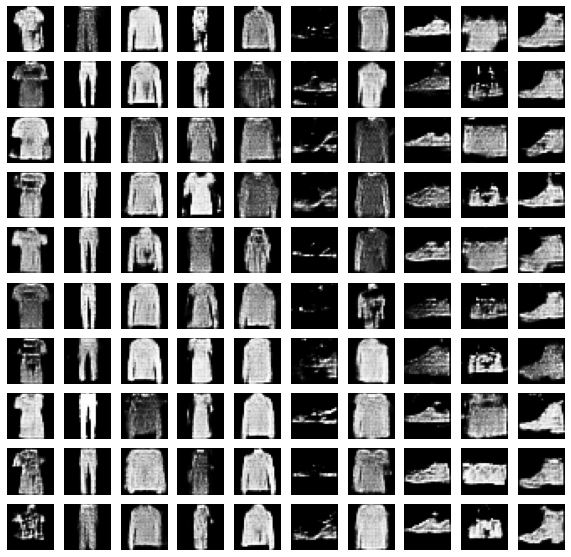

time epoch 100 is 30.597712516784668
CPU times: user 14min 53s, sys: 1min 58s, total: 16min 51s
Wall time: 50min 41s


In [43]:
%%time
train(train_dataset, epochs)


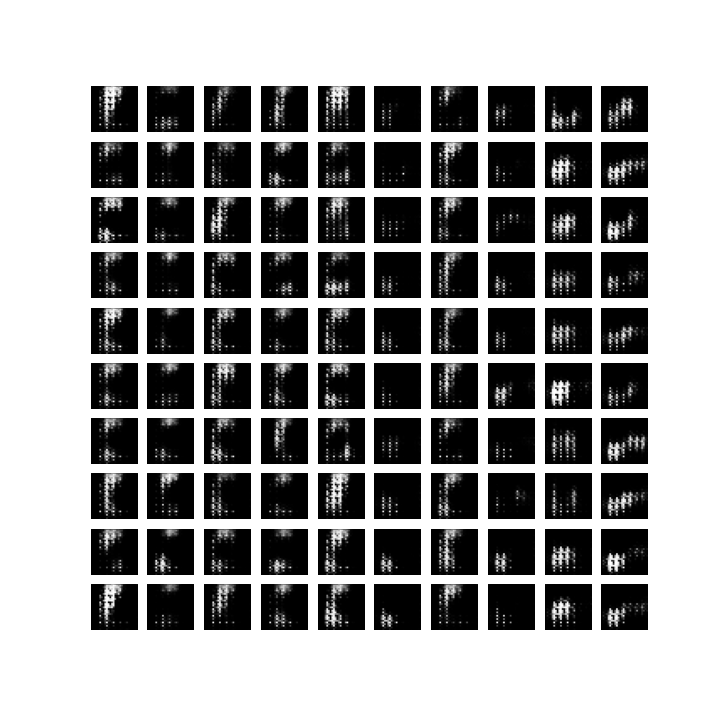

In [44]:
import imageio
from IPython.display import display,Image

anim_file = "dcgan.gif"
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob("image*.png")
  filenames = sorted(filenames)
  last = -1
  for i, filename in enumerate(filenames):
    frame = 2 *(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

display(Image(filename=anim_file, format='png'))

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))